# MPAS Ocean visualization

MPAS Ocean visualization notebook

***

In [1]:
import numpy as np
import xarray as xr
import sys
import yaml
import geojson
import fastjmd95 as jmd95
from scipy import signal, ndimage
from datetime import datetime, timedelta
from matplotlib import pyplot as plt, patches, path, colors, dates, ticker
from cartopy import crs, feature
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import postprocesstools as pptools

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

### Load postprocessed results

Load saved postprocessing netCDF files, and ancillary plotting data

In [2]:
# Load postprocessed netCDF
savepath = '/pscratch/sd/b/bmoorema/results/aggregated/new/new/'
meshNames, ctgys = ['LR', 'HR'], ['2D', 'WMT', 'transect']
ds, coords = {}, {}
for meshName in meshNames:
    coords[meshName], _, _ = pptools.load_coords(meshName)
    ds[meshName] = {ctgy: xr.open_dataset(f'{savepath}{meshName}_{ctgy}.nc') for ctgy in ctgys}

# Load bathymetry
f = '/pscratch/sd/b/bmoorema/data/ETOPO_2022_v1_60s_N90W180_bed.nc'
ds_bathy = xr.open_dataset(f)
ds_bathy = ds_bathy.sel(lon=slice(-83, 30, 10), lat=slice(48, 78, 10))
lons, lats, depths = [ds_bathy[name].values for name in ('lon', 'lat', 'z')]

# Load regions from geojson
fc = []
for region in ['iceland_rockall', 'irminger_sea', 'labrador_sea']:
    with open(f'../geojson/{region}.geojson') as f:
        fc.append(geojson.load(f)['features'][0])
fc = geojson.FeatureCollection(fc)

# Load observations
f = '/pscratch/sd/b/bmoorema/data/OSNAP_Streamfunction_201408_202006_2023.nc'
ds_osnap = xr.open_dataset(f).resample(TIME='1y').mean()

# Transects for each region
transect_dict = {
    'Iceland Basin': [('Reykjanes-OSNAP East',), ('Iceland-Faroe Ridge',)],
    'Irminger Sea': [('OSNAP East-Reykjanes',), ('Denmark Strait',)],
    'Labrador Sea': [('OSNAP West',), ('Davis Strait', 'Hudson Bay')],
    'All': [('OSNAP West', 'OSNAP East'), ('Davis Strait', 'Hudson Bay', 'Denmark Strait', 'Iceland-Faroe Ridge')],
}

***

### Plotting functions

In [3]:
def plot_study_area():
    """Plot study area map
    """
    
    # Make map figure
    fig, ax = plt.subplots(figsize=(10, 7.5), subplot_kw={'projection': crs.LambertConformal(-20, 70)})
    props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
    palette = plt.get_cmap('tab10').colors
    proj_ref = crs.PlateCarree()
    ax.set_extent([-58, 7, 50, 75])

    # Add coastlines
    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.add_feature(feature.LAND, color='gray')
    gl = ax.gridlines(
        linestyle=':', color='k', draw_labels=True,
        xlocs=range(-80, 41, 20), x_inline=False,
        ylocs=range(50, 81, 10), y_inline=False,
    )
    gl.bottom_labels, gl.right_labels = False, False

    # Add bathymetry
    lons, lats, depths = [ds_bathy[name].values for name in ('lon', 'lat', 'z')]
    c = ax.contourf(lons, lats, -depths, levels=range(0, 5001, 100), cmap='Blues', extend='max', transform=proj_ref, zorder=-10)

    # Add polygons
    proj_ref = crs.PlateCarree()
    for feat in fc['features']:
        xy = np.array(feat['geometry']['coordinates'][0])
        ax.add_patch(patches.Polygon(xy, fc='mistyrose', ec='k', lw=2, alpha=0.5, transform=proj_ref, zorder=-10))

    # Add annotations
    annotations = [
        {'str': 'Iceland\nBasin'       , 'xy': (0.63, 0.290), 'c': 'k', 'w': 'bold'  , 'r':   0},
        {'str': 'Irminger\nSea'        , 'xy': (0.42, 0.370), 'c': 'k', 'w': 'bold'  , 'r':   0},
        {'str': 'Labrador\nSea'        , 'xy': (0.13, 0.300), 'c': 'k', 'w': 'bold'  , 'r':   0},
        {'str': 'Greenland'            , 'xy': (0.38, 0.800), 'c': 'w', 'w': 'bold'  , 'r':   0},
        {'str': 'Nordic\nSeas'         , 'xy': (0.80, 0.600), 'c': 'w', 'w': 'bold'  , 'r':   0},
        {'str': 'North Atlantic\nOcean', 'xy': (0.30, 0.100), 'c': 'w', 'w': 'bold'  , 'r':   0},
        {'str': 'OSNAP'                , 'xy': (0.38, 0.225), 'c': 'k', 'w': 'normal', 'r': -18},
        {'str': 'East'                 , 'xy': (0.50, 0.175), 'c': 'k', 'w': 'normal', 'r':  -2},
        {'str': 'OSNAP West'           , 'xy': (0.20, 0.130), 'c': 'k', 'w': 'normal', 'r':  59},
        {'str': 'Denmark\nStrait'      , 'xy': (0.41, 0.610), 'c': 'k', 'w': 'normal', 'r':   0},
        {'str': 'Iceland-Faroe\nRidge' , 'xy': (0.71, 0.325), 'c': 'k', 'w': 'normal', 'r': -35},
        {'str': 'Reykjanes\nRidge'     , 'xy': (0.50, 0.265), 'c': 'k', 'w': 'normal', 'r':  46},
        {'str': 'Davis\nStrait'        , 'xy': (0.18, 0.660), 'c': 'k', 'w': 'normal', 'r': -22},
    ]
    for ann in annotations:
        ax.text(
            *ann['xy'], ann['str'], color=ann['c'], fontweight=ann['w'],
            ha='center', rotation=ann['r'], transform=ax.transAxes,
        )

    # Colorbar
    cax = fig.add_axes([0.45, 0.09, 0.45, 0.02])
    cbar = fig.colorbar(c, cax=cax, label='Depth [m]', orientation='horizontal', ticks=range(0, 5001, 1000))

    return fig, ax


def plot_circulation(depth=1000):
    """Plot 2D depth-averaged circulation at given depth
    """

    # Make figure
    proj_ref = crs.PlateCarree()
    subplot_kw, gridspec_kw = {'projection': crs.LambertConformal(-20, 70)}, {'hspace': 0.05, 'wspace': 0.05}
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)

    # Loop through meshes and panels
    for ax, meshName, label in zip(axs, ['LR', 'HR'], ['Low Resolution', 'High Resolution']):

        # Add map
        ax.set_extent([-55, 5, 45, 75])
        ax.coastlines(resolution='50m')
        ax.add_feature(feature.LAND, color='gray')

        # Get velocity and speed
        lons, lats = [ds[meshName]['2D'][name].values for name in ('lon', 'lat')]
        u, v = [ds[meshName]['2D']['velocity' + component].sel(depth=depth).mean(dim='time').values for component in ('Zonal', 'Meridional')]
        speed = np.sqrt(u**2 + v**2)

        # Plot speed
        c = ax.contourf(lons, lats, speed, levels=np.arange(0, 0.31, 0.02), cmap='OrRd', extend='max', transform=proj_ref)

        lons = pptools.downsample(lons, widths=(3,))
        lats = pptools.downsample(lats, widths=(2,))
        u, v = [pptools.downsample(var, widths=(2, 3)) for var in (u, v)]
        q = ax.quiver(lons, lats, u, v, scale=2, width=0.003, transform=proj_ref)
        ax.quiverkey(q, 0.42, 0.87, 0.1, '0.1 m s$^{-1}$', color='w', labelcolor='w')
        ax.set_title(label + ' (years 0-10)')

    cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, ticks=np.arange(0, 0.31, 0.1), label='Mean 0-1000 m speed [m s$^{-1}$]')
    
    return fig, axs


def plot_osnap_transport():
    """Plot OSNAP transport and density along the transect
    """

    # Make figure
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 2], 'wspace': 0.03, 'hspace': 0.1})
    ylim = [4.3, 0]

    # Label currents
    axs[0, 0].text(0.1, 1.02, 'Labrador\nCurrent', ha='center', transform=axs[0, 0].transAxes)
    axs[0, 0].text(1.025, 1.02, 'West/East\nGreenland Current', ha='center', transform=axs[0, 0].transAxes)
    axs[0, 1].text(0.35, 1.02, 'Irminger\nCurrent', ha='center', transform=axs[0, 1].transAxes)
    axs[0, 1].text(0.65, 1.02, 'North Atlantic\nCurrent', ha='center', transform=axs[0, 1].transAxes)

    # Contour label locations
    locs = [
        [(800, 3), (850, 1.5), (900, 0.5), (600, 0)],
        [(300, 3), (1000, 2), (1100, 1), (1000, 0.4)],
    ]

    # Loop through meshes and transects
    for row, meshName, label in zip(axs, ['LR', 'HR'], ['Low Resolution', 'High Resolution']):
        for ax, transectName, xlim, loc in zip(row, ['OSNAP West', 'OSNAP East'], [(0, 1400), (0, 2400)], locs):

            # Get transect variables
            ds_transect = ds[meshName]['transect'].sel(transectNames=transectName).mean(dim='time')
            ds_transect = ds_transect.sel(nEdges=~ds_transect.edges.isnull())
            distance = ds_transect.distance
            depth = coords[meshName]['refBottomDepth'] * 1e-3
            v, rho = [ds_transect[name].values.T for name in ('normalVelocity', 'potentialDensity')]
            v = np.ma.masked_equal(v, 0)
            rho = np.ma.masked_less(rho - 1000, 20)
            
            # Plot velocity pcolor and density contours
            c = ax.pcolormesh(distance, depth, v, vmin=-0.2, vmax=0.2, cmap='RdBu', linewidth=0.1)
            cs = ax.contour(distance, depth, rho, levels=[27.4, 27.7, 27.8, 27.9], colors='k', linewidths=0.75)
            
            # Add contour labels
            manual = loc[1:] if meshName == 'HR' and transectName == 'OSNAP West' else loc
            ax.clabel(cs, manual=manual)

            # Formatting
            c.set_edgecolor('face')
            ax.set_facecolor('gray')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            if meshName == 'HR':
                ax.text(0.02, 0.02, transectName, color='w', transform=ax.transAxes)
                ax.set_xlabel('Distance [km]')
            else:
                ax.xaxis.set_ticklabels('')
            if transectName == 'OSNAP West':
                ax.set_ylabel('Depth [km]')
            else:
                ax.text(0.99, 0.02, label, color='w', ha='right', transform=ax.transAxes)
                ax.yaxis.set_ticklabels('')

    # Add colorbar
    cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='Poleward velocity [m s$^{-1}$]', ticks=np.arange(-0.2, 0.21, 0.1))
    
    return fig, axs


def plot_binned_curve(ax, x, array, color=None, label=None, smoothing=False, force_zero=False):
    """Plot mean and variability of binned curve
    """
    
    # Set color (default black)
    color = 'k' if color is None else color
    
    # Get mean and percentile variability
    mean = array.mean(axis=0)
    offset = float(mean[-1]) if force_zero else 0
    mean = mean - offset
    var = [np.percentile(array, p, axis=0) - offset for p in (10, 90)]
    
    # Lowpass filter
    if smoothing:
        mean = pptools.lowpass(mean)
        var = [pptools.lowpass(bound) for bound in var]
    
    # Plot
    ax.fill_between(x, *var, fc=color, ec=color, alpha=0.15)
    ax.plot(x, mean, color=color, label=label)


def plot_osnap_overturning():
    """Plot OSNAP overturning in density space
    """

    # Make figure
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'hspace': 0.1})
    palette = plt.get_cmap('tab10').colors
    xlim, ylim = [27, 28], [-2.5, 17.5]

    # Loop through sections
    for ax, section, label in zip(axs, ['East', 'West'], ['(a)', '(b)']):

        # Formatting
        transectName = 'OSNAP ' + section
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(ls=':')
        ax.plot(xlim, [0, 0], 'k--')
        ax.text(0.01, 0.9, f'{label} {transectName}', transform=ax.transAxes)

        # Plot obs
        densityBins, overturning = [ds_osnap[name].values for name in ('LEVEL', 'T_' + section.upper())]
        plot_binned_curve(ax, densityBins, overturning, color='k', label='obs', force_zero=True)

        # Get transport from transect variables
        for meshName, color in zip(['LR', 'HR'], palette):

            # Plot overturning
            densityBins = ds[meshName]['WMT'].densityBins.values
            transport = ds[meshName]['WMT'].densityTransport.sel(transectNames=transectName).resample(time='1y').mean().values
            overturning = -np.cumsum(transport[:, ::-1], axis=1)[:, ::-1]
            plot_binned_curve(ax, densityBins, overturning, color=color, label=meshName)

    axs[0].xaxis.set_ticklabels('')
    axs[1].set_xlabel('Potential density ($\\rho - 1000$) [kg m$^{-3}$]')
    axs[1].set_ylabel('Transport stream function [Sv]', y=1.01)
    axs[1].legend()
    
    return fig, axs


def plot_1D_WMT(binName, xlim=None, ylim=None, xlabel=None):
    """Plot water mass transformation as a function of binName
    """

    # Make plot
    fig, axs = plt.subplots(3, 2, figsize=(10, 7), gridspec_kw={'hspace': 0.1, 'wspace': 0.05})
    palette = plt.get_cmap('tab10').colors

    # Loop through meshes, panels
    k = 0
    for row, regionName in zip(axs, transect_dict):

        # Formatting
        for ax in row:
            k += 1
            if xlim is not None:
                ax.set_xlim(xlim)
            if ylim is not None:
                ax.set_ylim(ylim)
            ax.grid(ls=':')
            ax.text(0.01, 0.9, f'({chr(96+k)})', transform=ax.transAxes)
            if regionName != 'Labrador Sea':
                ax.xaxis.set_ticklabels('')
        row[1].yaxis.set_ticklabels('')
        row[0].text(0.02, 0.04, regionName, transform=row[0].transAxes)

        # Loop through regions
        for meshName, color in zip(['LR', 'HR'], palette):

            # Property bins
            bins = ds[meshName]['WMT'][binName + 'Bins'].values

            # Water mass transformation
            binNameFull = binName + 'Total' if binName == 'density' else binName
            wmt = ds[meshName]['WMT'][binNameFull + 'Transformation'].sel(regionNames=regionName).resample(time='1y').mean()
            if binName == 'temperature':
                wmt = wmt.sum(dim='salinityBins').values
            elif binName == 'salinity':
                wmt = wmt.sum(dim='temperatureBins').values
            plot_binned_curve(row[0], bins, wmt, color=color, label=meshName, smoothing=True)

            # Get overturning from individual transects
            binNameFull = 'TS' if binName != 'density' else binName
            overturning = []
            for transectNames in transect_dict[regionName]:
                transportTotal = 0
                for transectName in transectNames:
                    transport = ds[meshName]['WMT'][binNameFull + 'Transport'].sel(transectNames=transectName).resample(time='1y').mean()
                    if binName == 'temperature':
                        transport = transport.sum(dim='salinityBins').values
                    elif binName == 'salinity':
                        transport = transport.sum(dim='temperatureBins').values
                    transportTotal = transportTotal + transport
                overturning.append(transportTotal)

            # Plot overturning
            overturning = -np.cumsum(np.subtract(*overturning)[:, ::-1], axis=1)[:, ::-1]
            plot_binned_curve(row[1], bins, overturning, color=color, label=meshName)
        
        # Add zero line
        for ax in row:
            ax.plot(ax.get_xlim(), [0, 0], 'k--')

    # Final formatting
    axs[2, 0].set_xlabel(xlabel, x=1.01)
    axs[1, 0].set_ylabel('Transformation or transport [Sv]')
    axs[0, 0].set_title('Surface water mass transformation')
    axs[0, 1].set_title('Overturning convergence')
    axs[0, 1].legend()
    
    return fig, axs


def plot_2D_WMT(bins):
    """Plot 2D transformation maps on the given list of density, T, S bins
    """
    
    # Contour levels
    levels = np.arange(-20, 21, 1)
    levels = levels[levels != 0]

    # Make figure
    proj_ref = crs.PlateCarree()
    subplot_kw, gridspec_kw = {'projection': crs.LambertConformal(-20, 70)}, {'hspace': 0.05, 'wspace': 0.05}
    fig, axs = plt.subplots(3, 2, figsize=(10, 10.5), subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)

    # Formatting
    for ax, title in zip(axs[0, :], ['Low resolution', 'High resolution']):
        ax.set_title(title)
    k = 0
    for ax in axs.ravel():
        k += 1
        ax.set_extent([-58, 7, 50, 75])
        ax.coastlines(resolution='50m')
        ax.add_feature(feature.LAND, color='gray')
        ax.text(0.12, 0.94, f'({chr(96+k)})', transform=ax.transAxes)

    # Loop through bins
    binNames, units = ['density', 'temperature', 'salinity'], ['kg m$^{-3}$', '$^{\circ}$C', 'PSU']
    for row, bn, binName, unit in zip(axs, bins, binNames, units):
        
        # Define cases (mostly for density conventions)
        dimName, fieldName, binNameFull, conv, binSize, P = binName + 'Bins', binName, binName, 0, 0.05, [10, 90]
        if binName == 'density':
            fieldName, binNameFull, conv, P = 'potentialDensity', binName + 'Total', 1000, [90, 10]
        if binName == 'temperature':
            binSize = 0.5
        
        # Makeslice
        slc = slice(bn-binSize, bn+binSize)
        
        # Loop through panels and meshes
        for ax, meshName in zip(row, ['LR', 'HR']):

            # Plot transformation averaged over first 12 months of simulation on sigmaBin
            z = ds[meshName]['2D'][binNameFull + 'Transformation2D'].sel({dimName: slc}).mean(dim=['time', dimName])
            x, y, z = z.lon.values, z.lat.values, z.values
            c = ax.contourf(x, y, z, levels=levels, cmap='BrBG_r', extend='both', transform=proj_ref, zorder=-10)
            
            # Plot outcrop extent
            t = ds[meshName]['2D'].time
            field = ds[meshName]['2D'][fieldName].isel(time=t.dt.month.isin([1, 2, 12]), depth=0)
            for p, color in zip(P, ['k', 'r']):
                z = np.percentile(field, p, axis=0) - conv
                ax.contour(x, y, z, levels=[bn], colors=color, linewidths=0.75, transform=proj_ref)

        # Add panel labels
        row[0].text(-0.06, 0.5, f'{binName.capitalize()} ({bn:.1f} {unit})', rotation=90, va='center', transform=row[0].transAxes)

    # Add colorbars
    cax = fig.add_axes([0.21, 0.08, 0.6, 0.015])
    label = 'Surface transformation [$10^{-6}$ Sv km$^{-2}$]'
    fig.colorbar(c, cax=cax, label=label, ticks=range(-20, 21, 5), orientation='horizontal')

    # Add legend
    for color, p in zip(['r', 'k', ], [10, 90]):
        axs[0, 0].plot(0, 0, color, label=f'{p}th percentile')
    axs[0, 0].legend(loc=(0.08, 0), borderpad=0.3, handlelength=1.5, borderaxespad=0.15, labelspacing=0.3, frameon=False)
    
    return fig, axs


def plot_TS_volume():
    """Plot volumetric TS for the Iceland Basin, Irminger Sea and Lab Sea
    """

    # Make figure
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5), gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
    xlim, ylim = [34.2, 35.5], [-0.5, 10]

    # Loop through panels
    k = 0
    for row, meshName, meshNameLong in zip(axs, ['LR', 'HR'], ['Low Resolution', 'High Resolution']):
        for ax, regionName in zip(row, ['Labrador Sea', 'Irminger Sea', 'Iceland Basin']):

            # Formatting
            k += 1
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            if meshName == 'LR':
                ax.set_title(regionName)
                ax.xaxis.set_ticklabels('')
            if regionName != 'Labrador Sea':
                ax.yaxis.set_ticklabels('')
            if regionName == 'Iceland Basin':
                ax.text(1.01, 0.5, meshNameLong, rotation=-90, va='center', transform=ax.transAxes)
            ax.text(0.01, 0.93, f'({chr(96+k)})', transform=ax.transAxes, zorder=10)

            # Get bins
            bins = [ds[meshName]['WMT'][name + 'Bins'].values for name in ('salinity', 'temperature')]

            # Plot density
            rho = jmd95.rho(*np.meshgrid(*bins), 0) - 1000
            cs = ax.contour(*bins, rho, levels=np.arange(26, 29, 0.2), colors='gray', linewidths=0.3)
            ax.clabel(cs, manual=[(34.5, 7), (35.4, 5)])

            # Plot volume
            volume = ds[meshName]['WMT'].TSVolume.sel(regionNames=regionName).mean(dim='time').values
            volume = volume * 1e3
            c = ax.pcolormesh(*bins, volume, norm=colors.LogNorm(vmin=1e3, vmax=1e7), cmap='Reds')
            ax.contour(*bins, volume, levels=[1e6], colors='w', linewidths=0.75)

            annotations = [
                {'str': 'SPMW', 'xy': (35.20, 8.0), 'regions': ['Iceland Basin', 'Irminger Sea']},
                {'str': 'IW'  , 'xy': (35.17, 4.1), 'regions': ['Irminger Sea', 'Labrador Sea']},
                {'str': 'ISOW', 'xy': (35.25, 4.1), 'regions': ['Iceland Basin']},
                {'str': 'DSOW', 'xy': (35.00, 1.7), 'regions': ['Irminger Sea', 'Labrador Sea']},
                {'str': 'LSW' , 'xy': (34.71, 3.5), 'regions': ['Iceland Basin', 'Irminger Sea', 'Labrador Sea']},
                {'str': 'LDW' , 'xy': (34.95, 2.2), 'regions': ['Iceland Basin']},
            ]
            for ann in annotations:
                if regionName in ann['regions']:
                    ax.text(*ann['xy'], ann['str'], ha='center', va='center')

    # Final formatting and colorbar
    axs[1, 1].set_xlabel('Salinity [PSU]')
    axs[1, 0].set_ylabel('Temperature [$^{\circ}$C]', y=1.01)
    label = 'Volume/binsize [km$^{3}$ $^{\circ}$C$^{-1}$ PSU$^{-1}$]'
    cax = fig.add_axes([0.22, 0, 0.6, 0.02])
    fig.colorbar(c, cax=cax, orientation='horizontal', ticks=[1e3, 1e4, 1e5, 1e6, 1e7], label=label)
    cax.plot([1e6, 1e6], [0, 1], 'w-', lw=2)
    
    return fig, axs


def plot_TS_WMT_panel(ax, ds, regionName):
    """Make a panel plot of WMT and transport in TS space for the given region
    """
    
    # Get bins
    bins = [ds[name + 'Bins'].values for name in ('salinity', 'temperature')]
    
    # Transport contours
    levels = np.array([1, 1.6, 2.5, 4, 6.3])
    levels = np.hstack([0.04, 0.06, 0.1 * levels, levels, 10 * levels, 100])
    levels = np.hstack([-levels[::-1], levels])

    # Plot OT
    OT = []
    for transectNames in transect_dict[regionName]:
        transportTotal = 0
        for transectName in transectNames:
            transport = ds.TSTransport.sel(transectNames=transectName).mean(dim='time').values
            transportTotal = transportTotal + transport
        OT.append(transportTotal)
    OT = ndimage.gaussian_filter(np.subtract(*OT) * 1e3, 1)
    c = ax.contourf(*bins, OT, levels=levels, norm=colors.SymLogNorm(1), cmap='RdBu', extend='both', zorder=-10)
    ax.contour(*bins, OT, levels=[-10, 10], colors='w', linestyles='-', linewidths=0.75, zorder=-9)

    # Plot WMT
    xy = [pptools.downsample(dim) for dim in bins]
    ST = []
    for name in ['salinity', 'temperature']:
        var = ds[name + 'Transformation']
        if regionName == 'All':
            var = var.sel(regionNames=list(transect_dict.keys())[:3]).sum(dim='regionNames')
        else:
            var = var.sel(regionNames=regionName)
        ST.append(pptools.downsample(var.mean(dim='time').values))
    mask = np.sqrt(ST[0]**2 + ST[1]**2) < 1e-2
    ST = [np.ma.masked_where(mask, var) for var in ST]
    q = ax.quiver(*xy, *ST, scale=1.5, width=0.005, zorder=-8)

    # Plot density
    rho = jmd95.rho(*np.meshgrid(*bins), 0) - 1000
    cs = ax.contour(*bins, rho, levels=np.arange(25.8, 29, 0.2), colors='gray', linewidths=0.3, zorder=-6)
    ax.clabel(cs, manual=[(34.2, 12), (34.7, 8), (35.3, 4)])

    # Formatting
    ax.set_xlim(33.9, 35.7)
    ax.set_ylim(-1.2, 12.5)
    
    return c, q


def plot_TS_WMT():
    """Plot WMT and transport in TS space for the three SPG regions
    """

    # Make figure
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5), gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

    # Loop through panels
    k = 0
    for row, meshName in zip(axs, ['LR', 'HR']):
        for ax, regionName in zip(row, ['Labrador Sea', 'Irminger Sea', 'Iceland Basin']):

            c, q = plot_TS_WMT_panel(ax, ds[meshName]['WMT'], regionName)
            
            # Add quiverkey
            if meshName == 'LR' and regionName == 'Labrador Sea':
                ax.text(0.99, 0.98, 'T,S transformation', ha='right', va='top', transform=ax.transAxes)
                qk = ax.quiverkey(q, 0.8, 0.85, 0.1, '0.1 Sv', labelpos='W')
                qk.set_zorder(0)

            # Formatting
            k += 1
            ax.text(0.01, 0.93, f'({chr(96+k)})', transform=ax.transAxes)
            if meshName == 'LR':
                ax.set_title(regionName)
                ax.xaxis.set_ticklabels('')
            if regionName != 'Labrador Sea':
                ax.yaxis.set_ticklabels('')

    # Final formatting
    axs[1, 1].set_xlabel('Salinity [PSU]')
    axs[1, 0].set_ylabel('Temperature [$^{\circ}$C]', y=1.01)
    for ax, label in zip(axs[:, -1], ['Low Resolution', 'High Resolution']):
        ax.text(1.01, 0.5, label, rotation=-90, va='center', transform=ax.transAxes)
    
    # Colorbar
    label = 'Transport/binsize [Sv $^{\circ}$C$^{-1}$ PSU$^{-1}$]'
    ticks, fmt = [-100, -10, -1, -0.1, 0.1, 1, 10, 100], ticker.LogFormatterSciNotation()
    pos = [axs[1, col].get_position() for col in (0, 2)]
    cax = fig.add_axes([pos[0].x0 + 0.1, 0, pos[1].x1 - pos[0].x0 - 0.2, 0.02])
    cbar = fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=ticks, format=fmt)
    cax.plot([-10, -10], [0, 1], 'w-', lw=2)
    cax.plot([10, 10], [0, 1], 'w-', lw=2)
    
    return fig, axs


def plot_TS_WMT_all():
    """Plot WMT and transport in TS space for the entire SPG
    """

    # Make figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.05})

    # Loop through panels
    for ax, meshName, title in zip(axs, ['LR', 'HR'], ['Low Resolution', 'High Resolution']):

        c, q = plot_TS_WMT_panel(ax, ds[meshName]['WMT'], 'All')

        # Add quiverkey
        if meshName == 'LR':
            ax.text(0.5, 0.98, 'T,S transformation', ha='center', va='top', transform=ax.transAxes)
            qk = ax.quiverkey(q, 0.4, 0.9, 0.1, '0.1 Sv', labelpos='W')
            qk.set_zorder(0)

        # Formatting
        ax.set_title(title)

    # Final formatting
    axs[0].set_xlabel('Salinity [PSU]', x=1.02)
    axs[0].set_ylabel('Temperature [$^{\circ}$C]')
    axs[1].yaxis.set_ticklabels('')
    
    # Colorbar
    label = 'Transport/binsize [Sv $^{\circ}$C$^{-1}$ PSU$^{-1}$]'
    ticks, fmt = [-100, -10, -1, -0.1, 0.1, 1, 10, 100], ticker.LogFormatterSciNotation()
    cax = fig.add_axes([0.21, -0.03, 0.6, 0.03])
    cbar = fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=ticks, format=fmt)
    cax.plot([-10, -10], [0, 1], 'w-', lw=2)
    cax.plot([10, 10], [0, 1], 'w-', lw=2)
    
    return fig, axs

***

### Study area map

Plot study area map

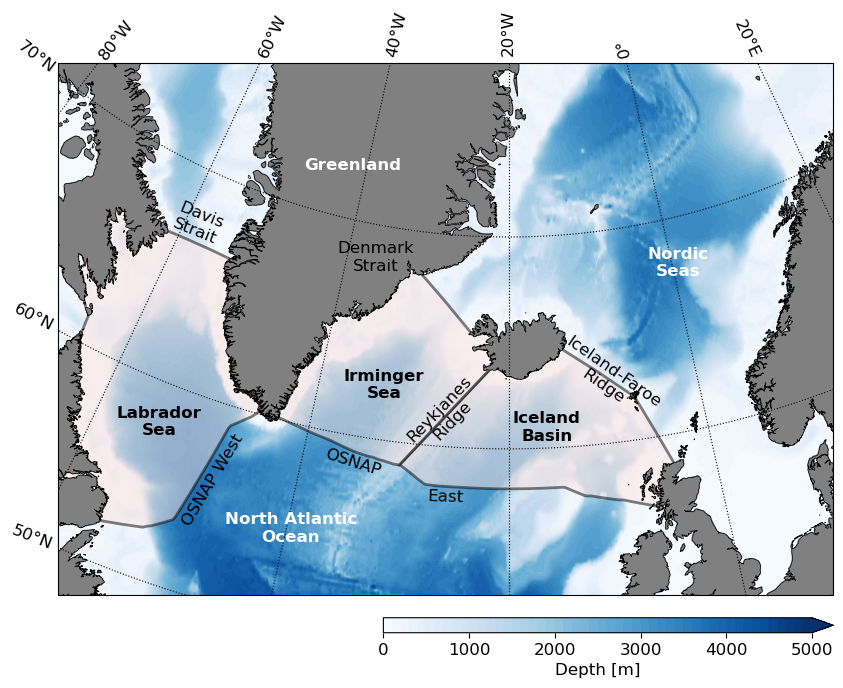

In [4]:
# Plot study area map
fig, ax = plot_study_area()

***

### 2D circulation

Plot 2D circulation

/global/cfs/cdirs/m4259/bmoorema/MPAS-QuickViz/ocean/AMOC/watermassanalysis/notebooks/../modules/postprocesstools.py:58: RuntimeWarning: Mean of empty slice
  array = np.nanmean(array.reshape(*args), axis=axis)
/global/cfs/cdirs/m4259/bmoorema/MPAS-QuickViz/ocean/AMOC/watermassanalysis/notebooks/../modules/postprocesstools.py:58: RuntimeWarning: Mean of empty slice
  array = np.nanmean(array.reshape(*args), axis=axis)


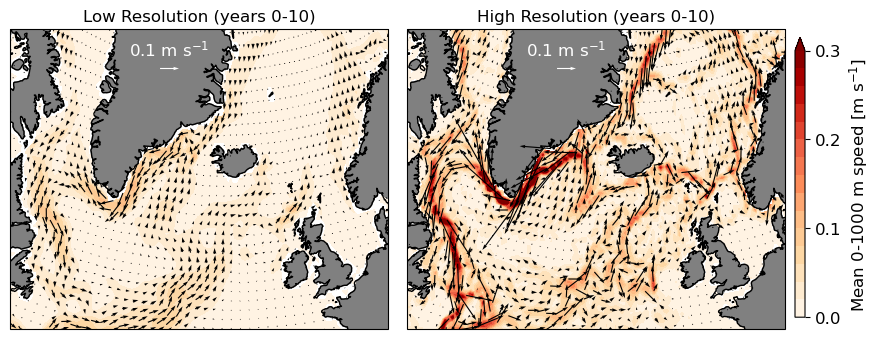

In [5]:
# Plot 2D circulation
fig, axs = plot_circulation()

***

### OSNAP transport

Plot OSNAP transport

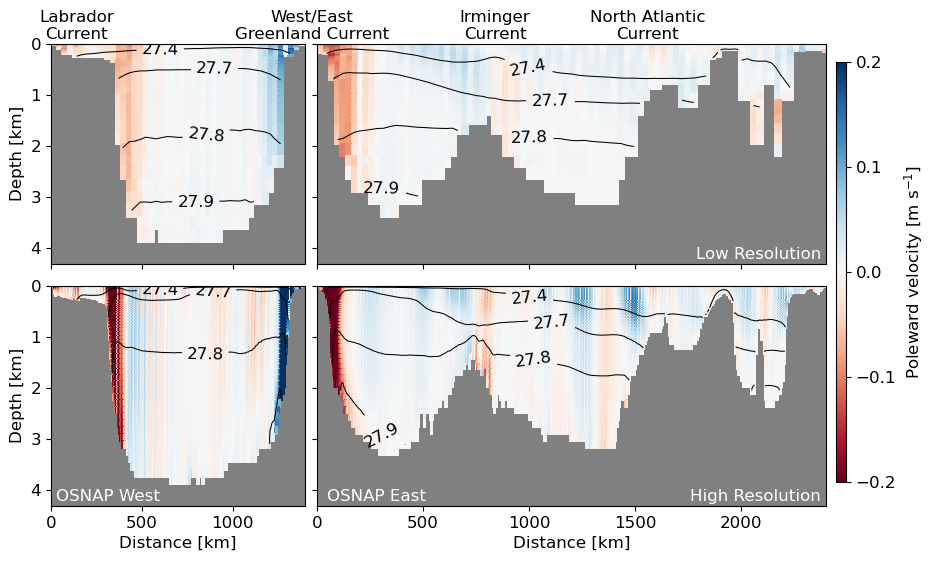

In [6]:
# Plot OSNAP transport
fig, axs = plot_osnap_transport()

***

### OSNAP overturning comparisons

Plot OSNAP overturning comparisons

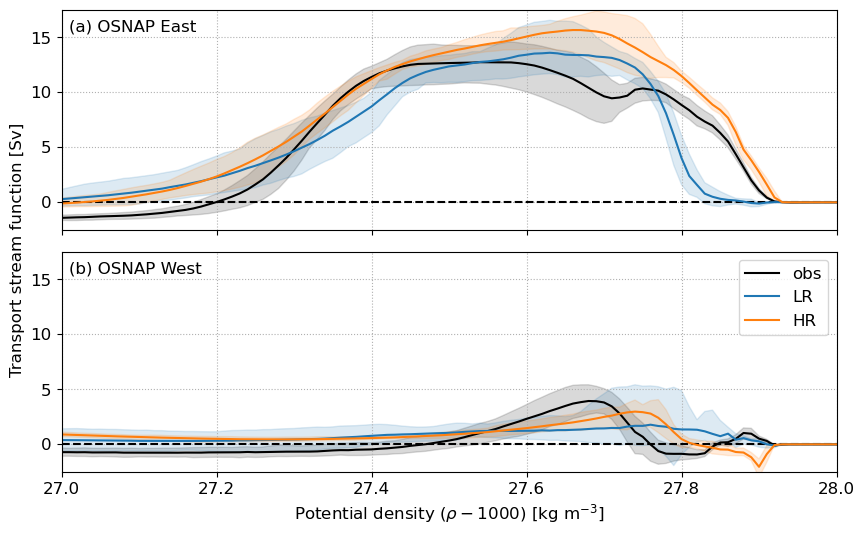

In [7]:
# Plot OSNAP overturning comparisons
fig, axs = plot_osnap_overturning()

***

### Property space plots

Density

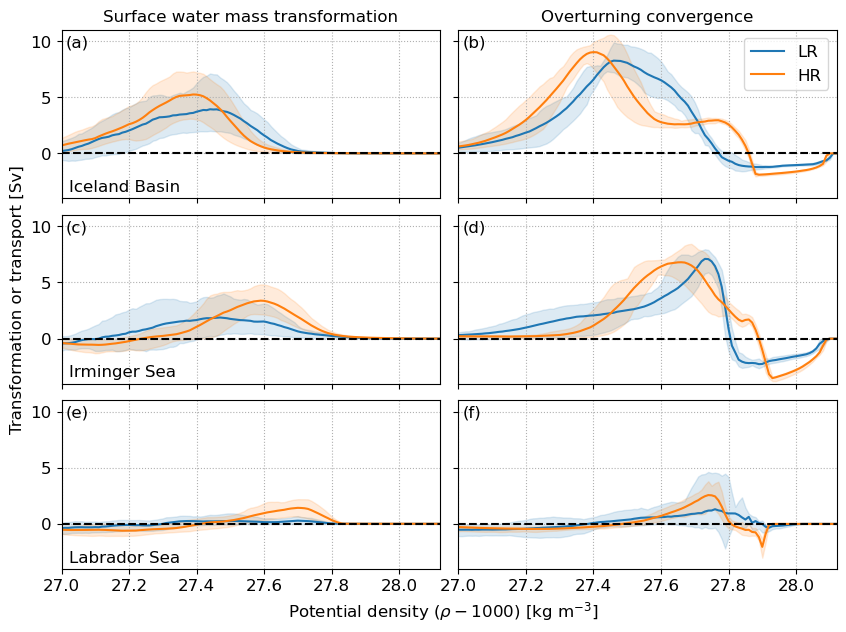

In [8]:
# Plot density-space
binName, xlim, ylim, xlabel = 'density', [27, 28.12], [-4, 11], 'Potential density ($\\rho - 1000$) [kg m$^{-3}$]'
fig, axs = plot_1D_WMT(binName, xlim=xlim, ylim=ylim, xlabel=xlabel)

Temperature

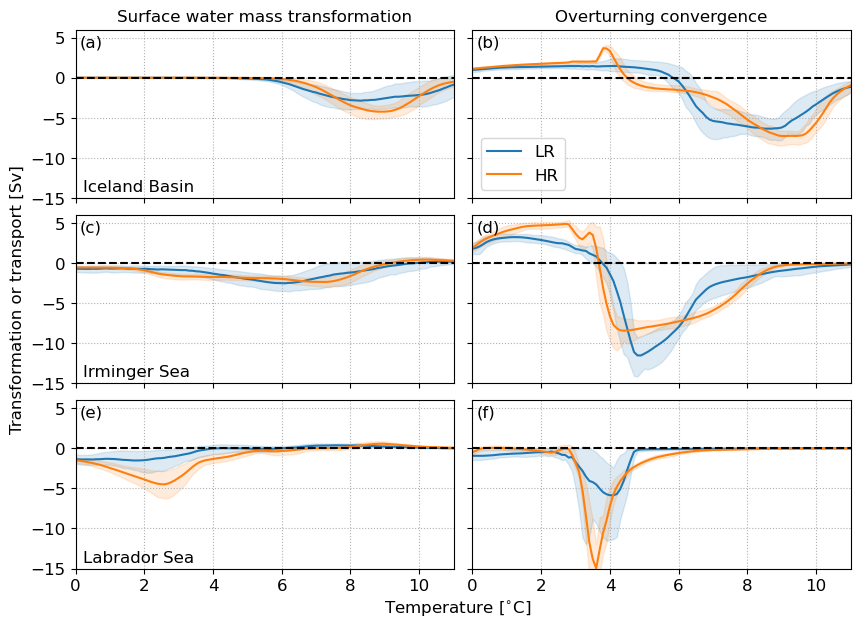

In [9]:
# Plot temperature space
binName, xlim, ylim, xlabel = 'temperature', [0, 11], [-15, 6], 'Temperature [$^{\circ}$C]'
fig, axs = plot_1D_WMT(binName, xlim=xlim, ylim=ylim, xlabel=xlabel)

Salinity

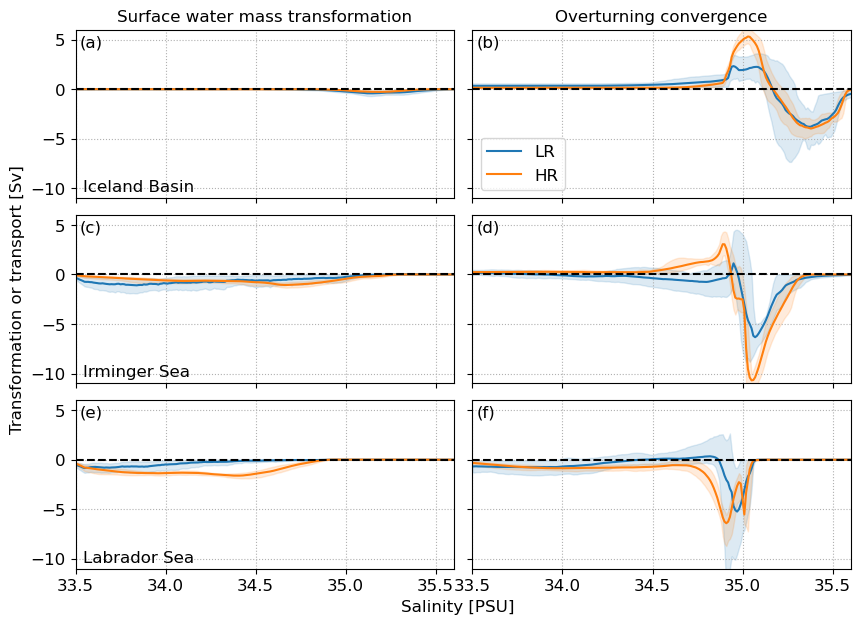

In [10]:
# Plot salinity space
binName, xlim, ylim, xlabel = 'salinity', [33.5, 35.6], [-11, 6], 'Salinity [PSU]'
fig, axs = plot_1D_WMT('salinity', xlim=xlim, ylim=ylim, xlabel=xlabel)

***

### 2D plots

Plot 2D transformation maps

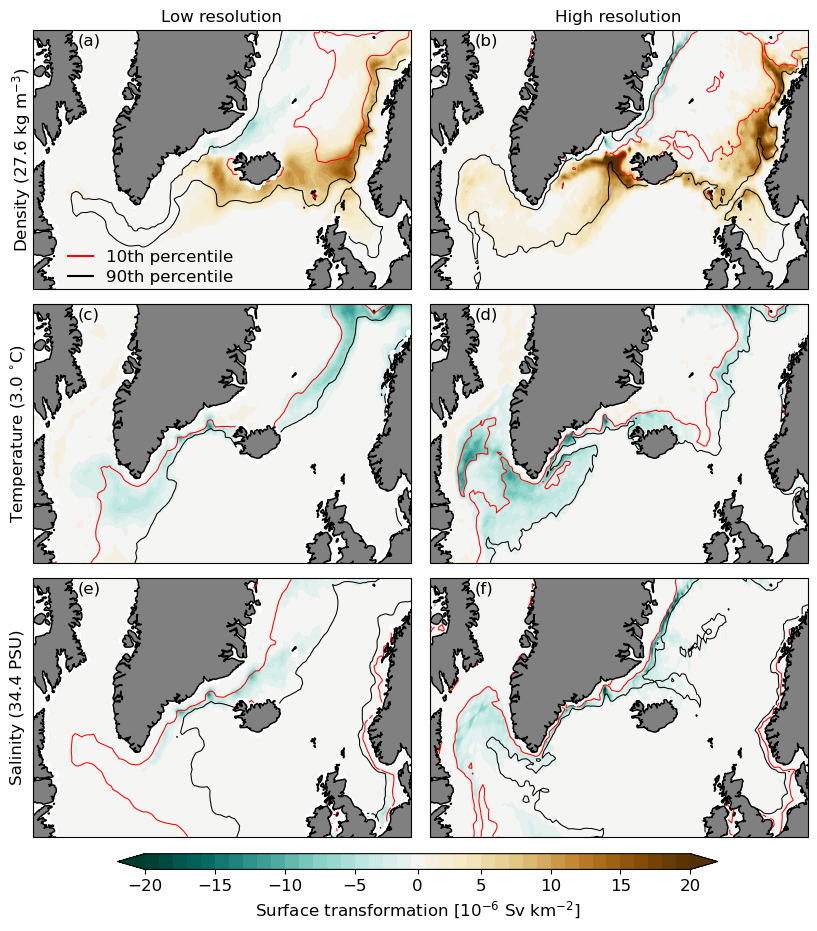

In [11]:
# Plot 2D transformation maps
bins = (27.6, 3, 34.4) # Density, temperature, salinity
fig, axs = plot_2D_WMT(bins)

***

### Volumetric TS plots

Plot volumetric TS

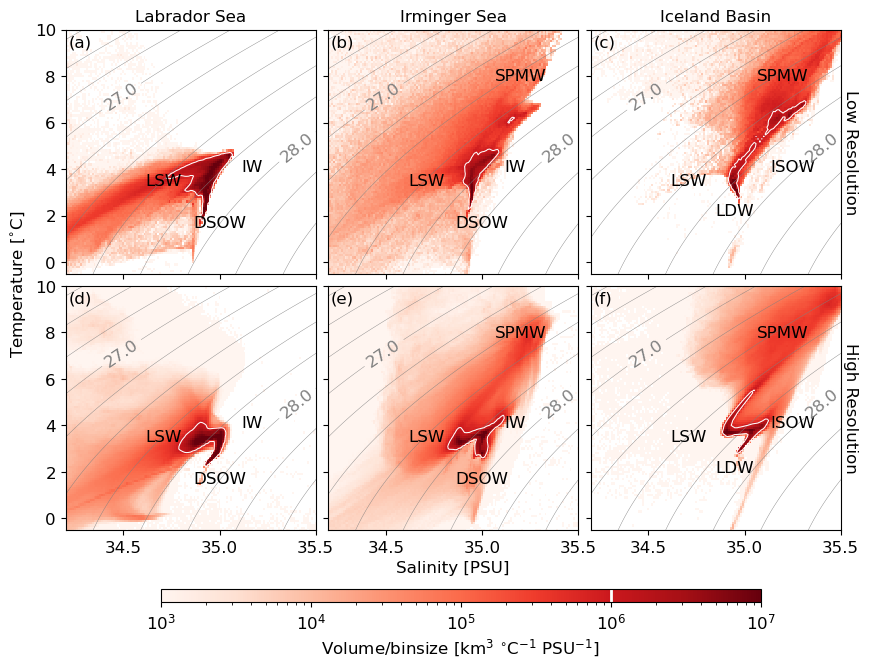

In [12]:
# Plot volumetric TS
fig, axs = plot_TS_volume()

***

### Transformation TS plots

Plot surface TS transformation and net transport in TS space

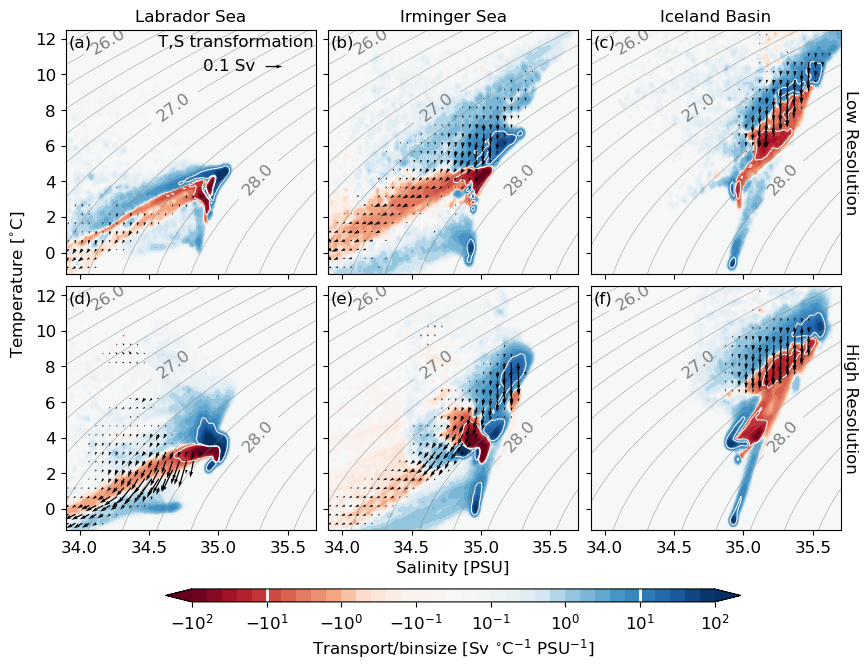

In [13]:
# Plot surface TS transformation and net transport in TS space
fig, axs = plot_TS_WMT()

Plot surface TS transformation and net transport in TS space for all SPG regions

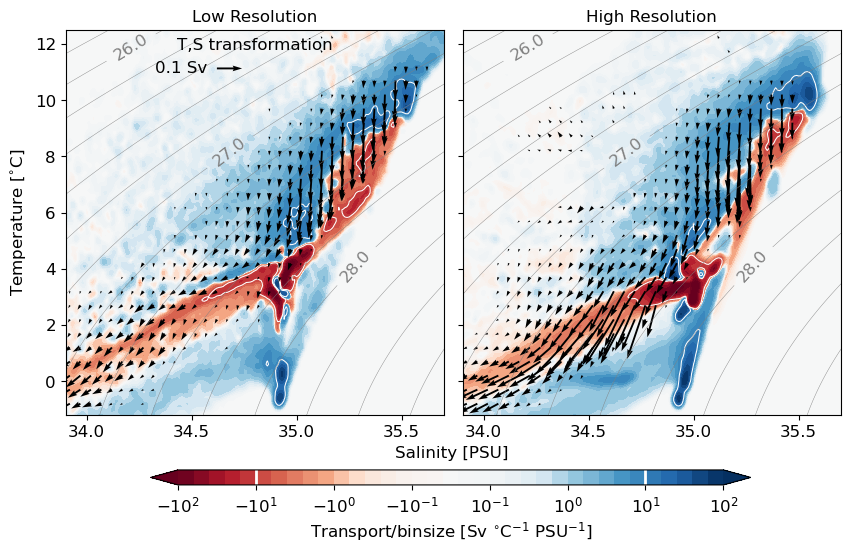

In [14]:
# Plot surface TS transformation and net transport in TS space for all SPG regions
fig, axs = plot_TS_WMT_all()